# Selecting the right bandwidth

In this problem we will try out band-width selection in two steps. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity

In [2]:
def read_bh_masses():
    """
    Read in black hole masses from CSV file
    """
    
    # You might need to update this
    fname = '../../../Datafiles/joint-bh-mass-table.csv'
    t = Table().read(fname)
    return t

In [3]:
t_bh = read_bh_masses()#

In [4]:
def show_one_bandwidth(t, bw, what='MBH', xmin=0, xmax=70):
    """
    Show the KDE estimate of the masses with one band-width
    """
    
    X = t[what][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel='gaussian').fit(X)
    
    xgrid = np.linspace(xmin, xmax, 200)
    ln_p_bh = kde.score_samples(xgrid[:, np.newaxis])
    p_bh = np.exp(ln_p_bh)
    
    h = plt.hist(t[what], density=True)
    plt.plot(xgrid, p_bh)
    plt.title("Bandwidth={0}".format(bw))
    plt.xlabel(r'$M_{BH}$')
    plt.ylabel(r'$P(M_{BH})$')
    
    return kde

def score_one_bandwidth(t, bw, kernel='gaussian'):
    """
    Fit a KDE and get its score on the fitted sample.
    
    It returns the log likelihood of the data.
    """
    X = t['MBH'][:, np.newaxis]
    kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(X)
    score = kde.score(X)
    
    return score

def score_many_bandwidths(t, kernel='gaussian', bws=None):
    """
    Fit many bandwidths
    """
    if bws is None:
        bws = np.linspace(1, 7.0, 100)
        
    scores = np.zeros_like(bws)
    for i, bw in enumerate(bws):
        scores[i] = score_one_bandwidth(t, bw, kernel=kernel)
    
    return bws, scores
    

In [5]:
MBH = t_bh['MBH']

In [6]:
bws, scores  = score_many_bandwidths(t_bh)

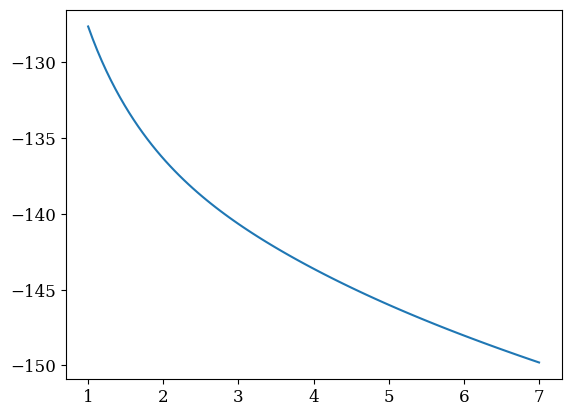

In [7]:
plt.plot(bws, scores)

## Implement k-fold CV next.

In [10]:
# I will do N-fold CV here. This divides X into N_folds
n_splits = 10
kf = KFold(n_splits=n_splits)
lnP = 0.0

In [11]:
# Create a new variable with the black hole masses for this CV
X = MBH[:, np.newaxis]

In [12]:
for train, test in kf.split(X):
    x_train = X[train, :]
    x_test = X[test, :]

    kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(x_train)
    log_prob = kde.score(x_test)
    lnP += log_prob

In [13]:
lnP

-158.91584311143546

In [14]:
def many_kfolds(t, bws=None):
    if bws is None:
        bws = np.linspace(1, 7.0, 100)
        
    scores = np.zeros_like(bws)
    lnPs = np.zeros_like(bws)
    for i, bw in enumerate(bws):
    
        lnP = 0.0
        for train, test in kf.split(X):
            x_train = X[train, :]
            x_test = X[test, :]

            kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(x_train)
            log_prob = kde.score(x_test)
            lnP += log_prob
            
        lnPs[i] = lnP
        
    return bws, lnPs

In [15]:
bws, lnPs = many_kfolds(t_bh)

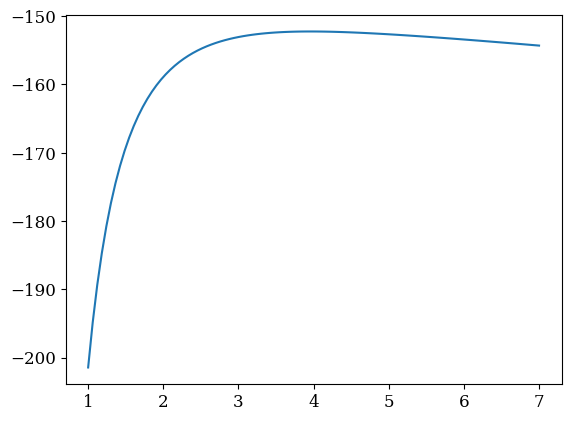

In [16]:
plt.plot(bws, lnPs)

In [17]:
np.argmax(lnPs)

49

In [18]:
bws[49]

3.9696969696969697

KernelDensity(bandwidth=3.9696969696969697)

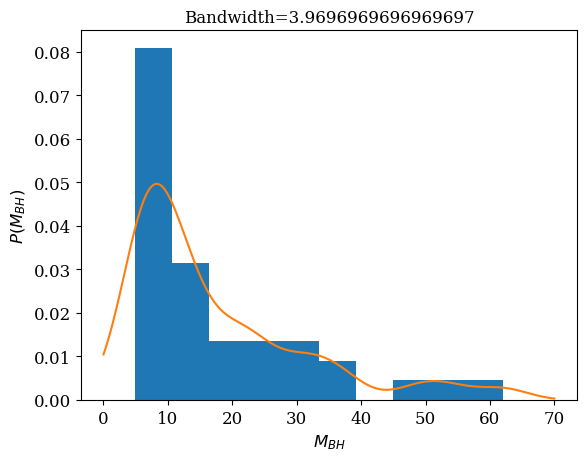

In [19]:
show_one_bandwidth(t_bh, bws[49], what='MBH', xmin=0, xmax=70)